In [22]:
import pandas as pd
filename = r'C:\tmp\data\Nanopore data Waad Tombo files\Own601-data\barcode10CP10.xlsx'
# filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode04_Waad601.xlsx'
filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode05_WaadR1.xlsx'
filename = r'C:\tmp\data\Nanopore data Waad Tombo files\barcode06_WaadR2.xlsx'

df = pd.read_excel(filename)
columns = df.columns[0:5]

In [10]:
from tqdm import tqdm

# Compute compound LLR by summing over a window of 147 bp

window = 147
llr_df = df.copy()
for col in tqdm(df.columns):
    llr_df[col] = df[col].rolling(window=window, min_periods=1).sum()/window


100%|██████████| 708/708 [00:06<00:00, 115.66it/s]


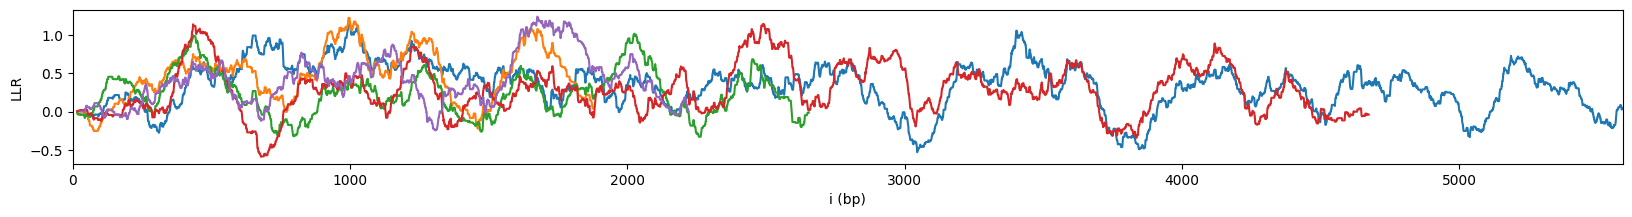

In [11]:
import matplotlib.pyplot as plt

# Plot a couple of examples

for col in columns:
    plt.plot(llr_df[col])
plt.xlabel('i (bp)')
plt.ylabel(f'LLR')
# plt.ylim(-1,1.5)
plt.xlim(0, len(llr_df))
plt.gcf().set_size_inches(20, 2)

plt.show()

In [12]:
import numpy as np

# Convert LLR to probability to nulcesomse occupancy using Vanderlick's formula
# https://doi.org/10.1103/PhysRevA.34.5130
# LLR should be converted to a free energy landscape, using DeltaG for nucleosome formation 

def vanderlick(llr, delta_g=-20, handles = 1000, convolve = 147):

    llr = np.concatenate([np.zeros(handles), llr, np.zeros(handles)])
    llr = np.nan_to_num(llr)
    n = len(llr)
    
    energy_landscape = delta_g*(1-llr)
    footprint = 147

    forward = np.zeros(n)
    for i in range(n):
        tmp = sum(forward[ max( i - footprint , 0):i])
        forward[i] = np.exp(energy_landscape[i] - tmp)

    backward = np.zeros(n)
    r_forward = forward[::-1]
    for i in range(n):
        backward[i] = 1 - sum(r_forward[max(i - footprint , 0):i]* backward[max(i - footprint,0):i])

    P = forward * backward[::-1]

    if convolve >1:
        P = convolve*np.convolve(P, np.ones(convolve)/convolve, mode='same')
    return P[handles:-handles]

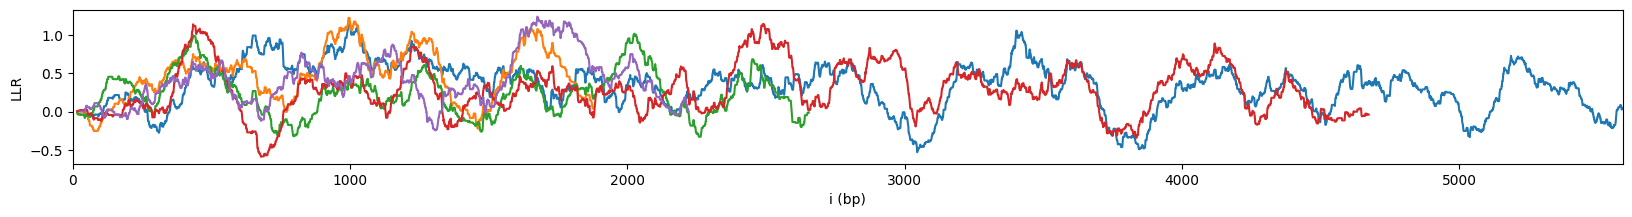

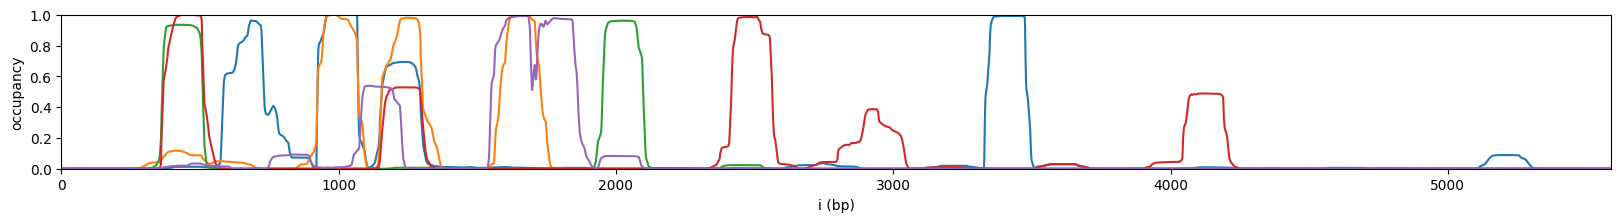

In [13]:
# Plot a couple of examples

for c in columns:
    plt.plot(llr_df[c])
plt.xlabel('i (bp)')
plt.ylabel(f'LLR')
plt.gcf().set_size_inches(20, 2)
plt.xlim(0, len(llr_df.index))
plt.show()

for c in columns:
    plt.plot(vanderlick(llr_df[c]))
plt.xlabel('i (bp)')
plt.ylabel(f'occupancy')
plt.gcf().set_size_inches(20, 2)
plt.xlim(0, len(llr_df.index))
plt.ylim(0, 1)
plt.show()

In [14]:
# Convert LLR to nucleosome occupancy

nuc_df = llr_df.copy()
for c in tqdm(llr_df.columns):
    nuc_df[c] = vanderlick(llr_df[c])

100%|██████████| 708/708 [02:39<00:00,  4.45it/s]


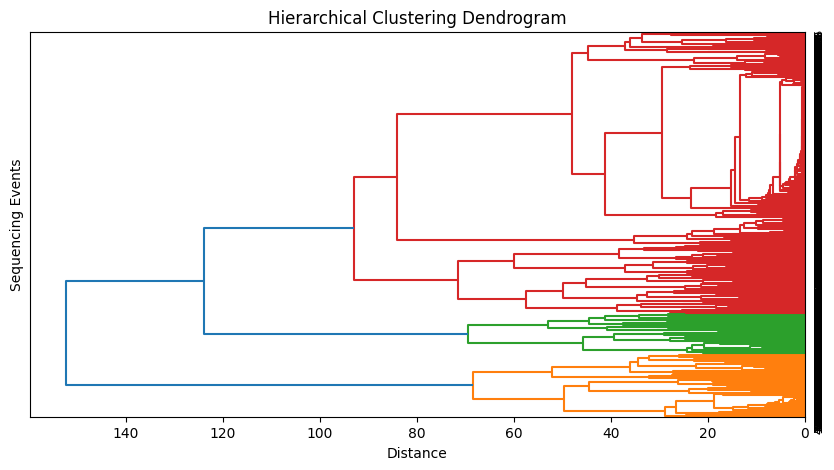

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute dendogram

Z = linkage(nuc_df.T, method='ward')

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Sequencing Events')
dendrogram(Z, orientation='left', leaf_rotation=90., leaf_font_size=8.)
plt.show()

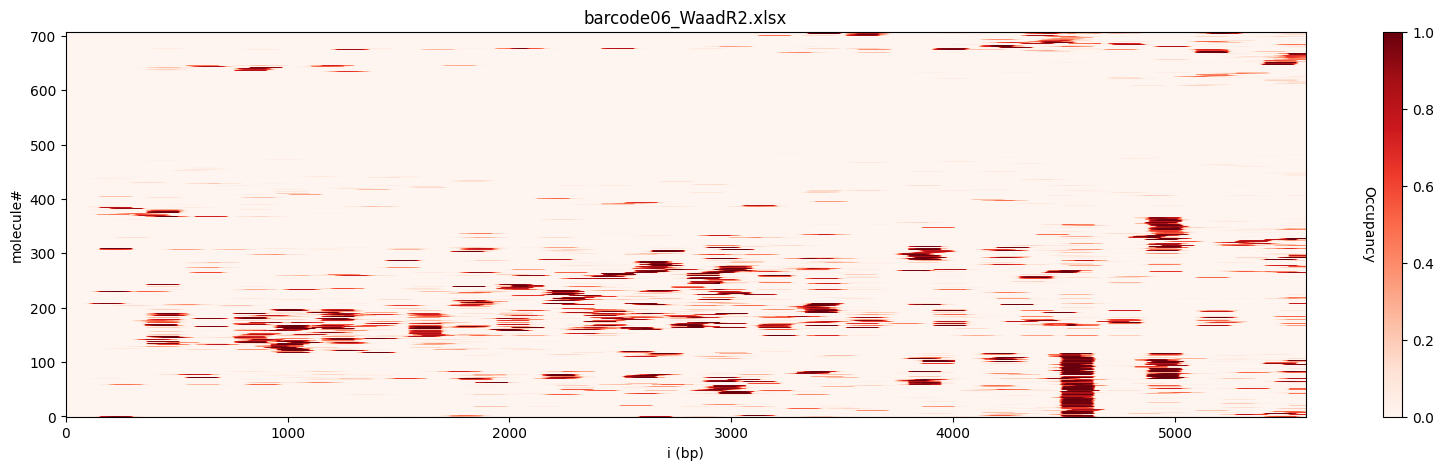

In [19]:
# plot the nucleosome occupancy matrix, ordered by the dendogram

clustering_order = dendrogram(Z, no_plot=True)['leaves']

# column_names_ordered = llr_df.sum().sort_values(ascending=False).index
# column_name_to_index = {name: index for index, name in enumerate(df.columns)}
# clustering_order = [column_name_to_index[name] for name in column_names_ordered]

df_reordered = nuc_df.iloc[:, clustering_order]

im = plt.imshow(df_reordered.swapaxes("index", "columns"), cmap='Reds', interpolation='nearest', vmin=0, vmax=1, origin='lower', aspect = 'auto')
plt.ylabel(f'molecule#')
plt.xlabel('i (bp)')
# plt.ylim(0, 300)
cbar = plt.colorbar(im)
cbar.set_label('\n\n\n\nOccupancy', rotation=270)
plt.title(filename.split('\\')[-1])
plt.gcf().set_size_inches(20, 5)